# Imports / Set Up

In [1]:
# Specific to NERSC: Set up kernel using: https://docs.nersc.gov/services/jupyter/how-to-guides/
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# might have issues with too many files being opened at once
# this will prevent that
import torch.multiprocessing
import torch.nn.functional as f
from neuralop.data.datasets.darcy import DarcyDataset
from neuralop.utils import get_project_root
from torch.utils.data import DataLoader

from operator_aliasing.utils import filter_batch
from operator_aliasing.utils import get_2d_low_pass_filter
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_model_preds

torch.multiprocessing.set_sharing_strategy('file_system')

root_dir = get_project_root() / 'neuralop/data/datasets/data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

device=device(type='cuda')


# Testing Data Generation

Loading test db for resolution 16 with 32 samples 
Loading test db for resolution 16 with 32 samples 


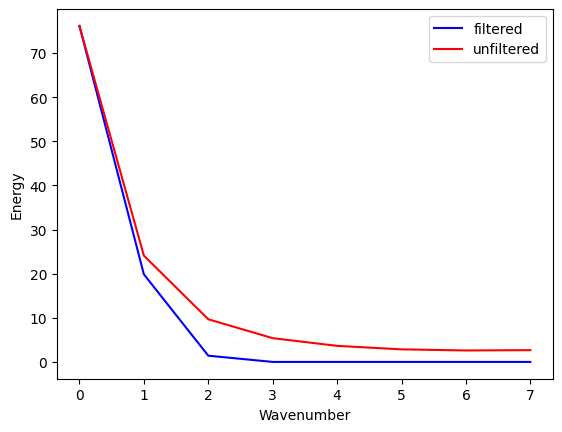

Text(0.5, 1.0, 'Filtered lim = 3')

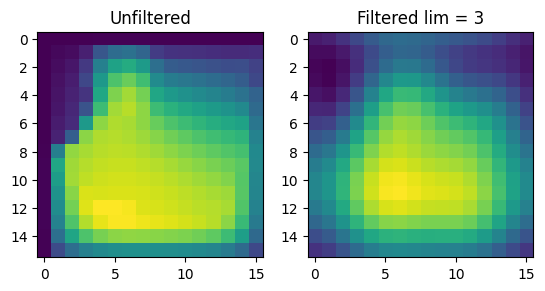

In [7]:
from operator_aliasing.data.utils import get_dataset

data_kwargs = {
    'dataset_name': 'darcy',
    'filter_lim': 3,
    'img_size': 16,
    'downsample_dim': -1,
    'train': True,
}

dataset = get_dataset(**data_kwargs)
samples = len(dataset)
s = data_kwargs['img_size']
filtered_sp = get_energy_curve(
    dataset[:samples]['x'].reshape(samples * 1, s, s)
)
filtered_sample = dataset[0]

data_kwargs = {
    'dataset_name': 'darcy',
    'filter_lim': -1,
    'img_size': 16,
    'downsample_dim': -1, #5, -1
    'train': True,
}

dataset = get_dataset(**data_kwargs)
samples = len(dataset)
s = data_kwargs['img_size']
if data_kwargs['downsample_dim'] != -1:
    s = data_kwargs['downsample_dim']

inputs = [dataset[i]['x'] for i in range(samples)]
labels = [dataset[i]['y'] for i in range(samples)]
dataset_samples = {'x': torch.cat(inputs), 'y': torch.cat(labels)}
unfiltered_sp = get_energy_curve(
    dataset_samples['x'].reshape(samples * 1, s, s)
)
unfiltered_sample = dataset[0]

plt.plot(filtered_sp, color='blue', label='filtered')
plt.plot(unfiltered_sp, color='red', label='unfiltered')
plt.ylabel('Energy')
plt.xlabel('Wavenumber')
plt.legend()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(unfiltered_sample['y'][0, :, :])
axes[0].set_title('Unfiltered')
axes[1].imshow(filtered_sample['y'][0, :, :])
axes[1].set_title('Filtered lim = 3')

In [8]:
dataset[0]['x'].shape

torch.Size([1, 16, 16])

# Visualizing Results from first set of experiments

1. Loss curves -- why do columns 5/9/11 behave differently?? (something to do w/ odd values)??
2. Heatmpats for new experiments (lim vs. downsample)
3. Spectrums

Index(['epoch', 'train_loss', 'test'], dtype='object')


/tmp/ipykernel_666841/3118320039.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(-3, -1.5), loc='lower center', ncols=3)
/tmp/ipykernel_666841/3118320039.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


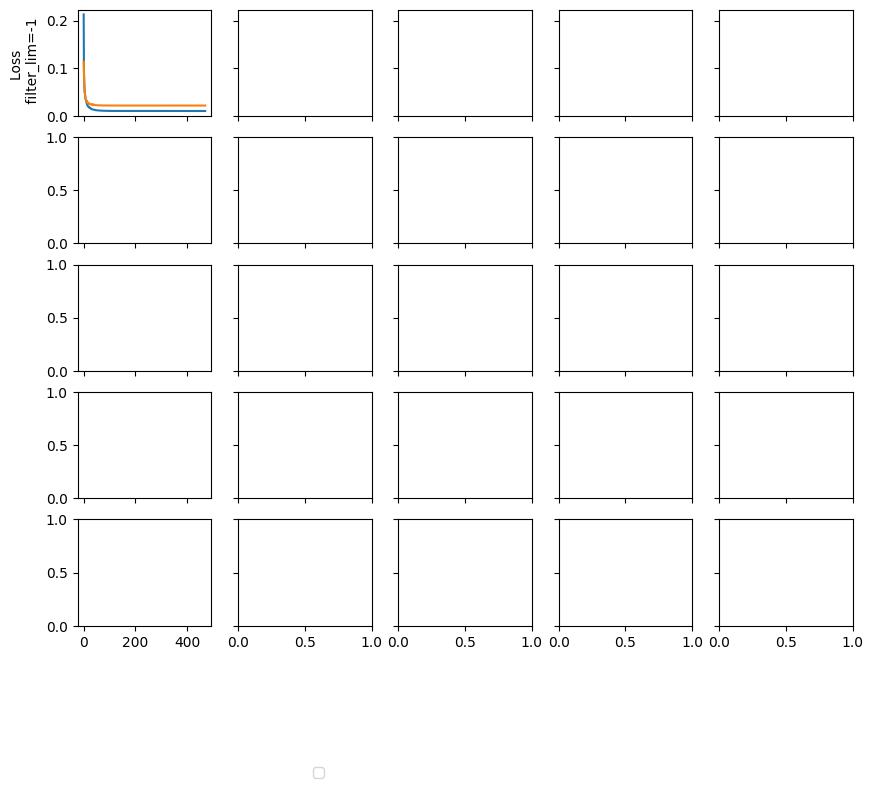

In [37]:
# Loss curves

fig, axes = plt.subplots(
    nrows=5, ncols=5, sharey='row', sharex='col', figsize=(10, 8)
)
ckpt_path = (
    '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
)
for x_idx, downsample_dim in enumerate([-1]):
    for y_idx, filter_lim in enumerate([-1]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_name = f'{ckpt_path}/{ckpt_dir}/train_stats.csv'
        df = pd.read_csv(ckpt_name)
        print(df.columns)
        for ylabel in [
            'train_loss',
            'test',
        ]:
            sns.lineplot(
                df, x='epoch', y=ylabel, label=ylabel, ax=axes[y_idx, x_idx]
            )
            axes[y_idx, x_idx].set_xlabel(
                f'Epoch \n downsample = {downsample_dim}'
            )
            axes[y_idx, x_idx].get_legend().remove()
            axes[y_idx, x_idx].set_ylabel(f'Loss \n {filter_lim=}')

plt.legend(bbox_to_anchor=(-3, -1.5), loc='lower center', ncols=3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_666841/3681092306.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


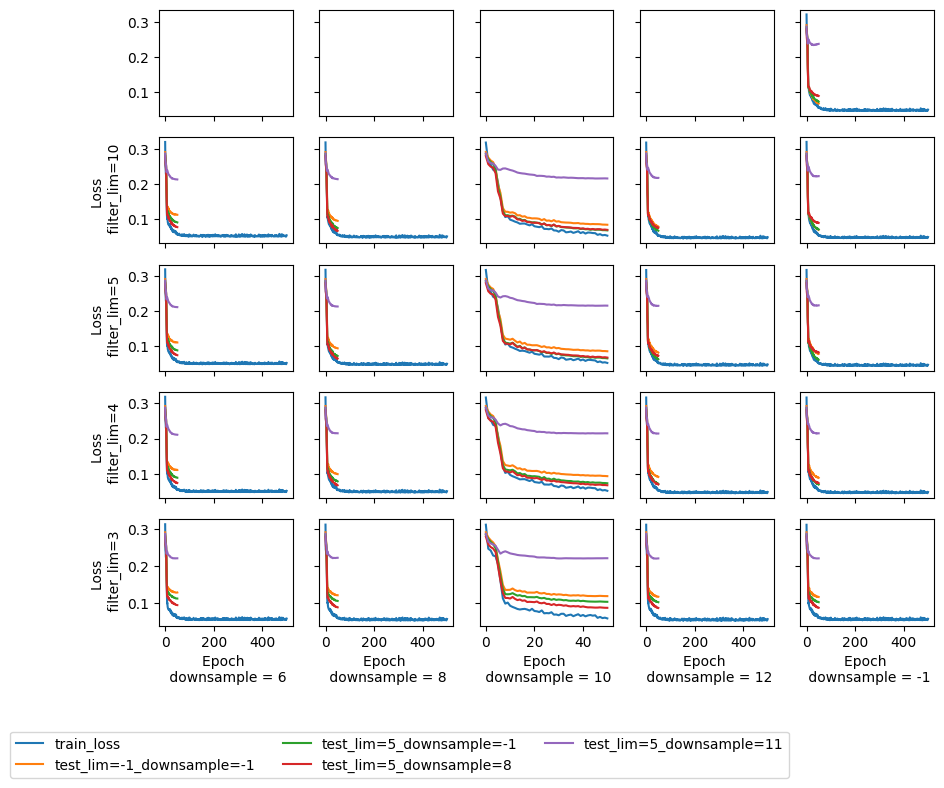

In [25]:
# Loss curves

fig, axes = plt.subplots(
    nrows=5, ncols=5, sharey='row', sharex='col', figsize=(10, 8)
)
ckpt_path = (
    '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
)
for x_idx, downsample_dim in enumerate([6, 8, 10, 12, -1]):
    for y_idx, filter_lim in enumerate([-1, 10, 5, 4, 3]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_name = f'{ckpt_path}/{ckpt_dir}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        for ylabel in [
            'train_loss',
            'test_lim=-1_downsample=-1',
            'test_lim=5_downsample=-1',
            'test_lim=5_downsample=8',
            'test_lim=5_downsample=11',
        ]:
            sns.lineplot(
                df, x='epoch', y=ylabel, label=ylabel, ax=axes[y_idx, x_idx]
            )
            axes[y_idx, x_idx].set_xlabel(
                f'Epoch \n downsample = {downsample_dim}'
            )
            axes[y_idx, x_idx].get_legend().remove()
            axes[y_idx, x_idx].set_ylabel(f'Loss \n {filter_lim=}')

plt.legend(bbox_to_anchor=(-3, -1.5), loc='lower center', ncols=3)
plt.tight_layout()
plt.show()

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3/50_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 


/tmp/ipykernel_666841/3342518497.py:79: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


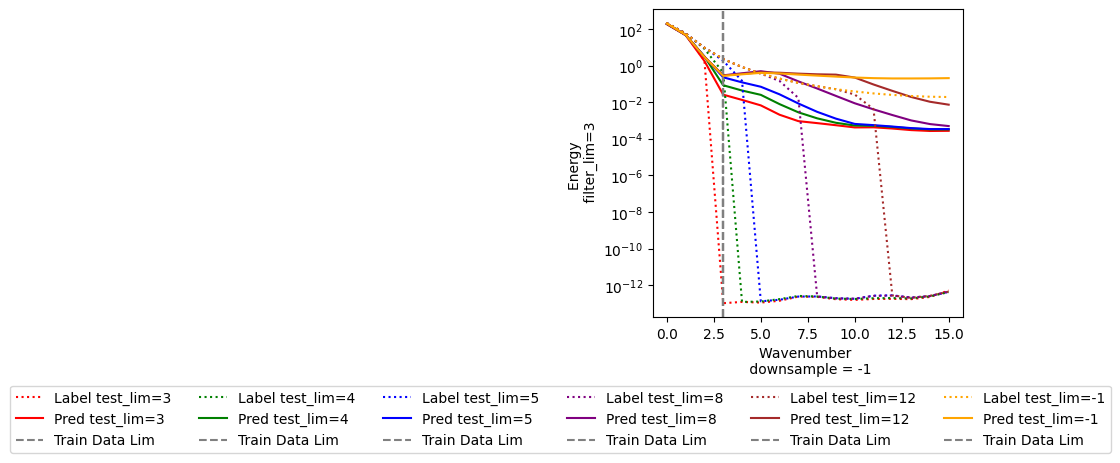

In [10]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt

colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
fig, axes = plt.subplots(
    nrows=1, ncols=1, sharey='row', sharex='col', figsize=(4, 4)
)
ckpt_path = (
    '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
)
for x_idx, downsample_dim in enumerate([-1]):
    for y_idx, filter_lim in enumerate([3]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for color_idx, test_lim in enumerate([3, 4, 5, 8, 12, -1]):
            for test_down in [-1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': True,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']

                # get label + spectrum
                label_spectrum = get_energy_curve(
                    dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                # get model pred + spectrum
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()
                pred_spectrum = get_energy_curve(
                    model_preds_test[:samples].reshape(samples * 1, s, s)
                )
                axes.set_yscale('log')
                axes.plot(
                    label_spectrum,
                    label=f'Label {test_lim=}',
                    linestyle=":",
                    color=colors[color_idx],
                )
                axes.plot(
                    pred_spectrum,
                    label=f'Pred {test_lim=}',
                    color=colors[color_idx],
                )
                axes.axvline(x = filter_lim, color = 'grey', linestyle="--", label = 'Train Data Lim')
                
                axes.set_xlabel(f'Wavenumber \n downsample = {downsample_dim}')
                axes.set_ylabel(f'Energy \n {filter_lim=}')

plt.legend(bbox_to_anchor=(1.5, -0.2), ncols=6)
plt.tight_layout()
plt.show()

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 


/tmp/ipykernel_666841/172205466.py:102: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


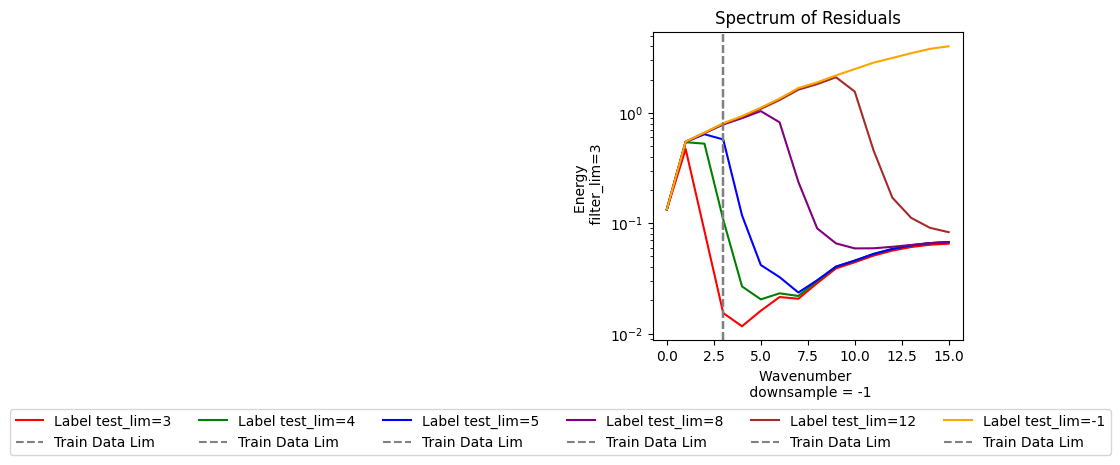

In [33]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt

colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
fig, axes = plt.subplots(
    nrows=1, ncols=1, sharey='row', sharex='col', figsize=(4, 4)
)
ckpt_path = (
    '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
)
for x_idx, downsample_dim in enumerate([-1]):
    for y_idx, filter_lim in enumerate([3]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for color_idx, test_lim in enumerate([3, 4, 5, 8, 12, -1]):
            for test_down in [-1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': True,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']

                # get model pred
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()

                # compute residuals
                residuals = []
                for i in range(model_preds_test.shape[0]):
                    residual = model_preds_test[i].to('cpu') - dataset[:samples]['y'].squeeze()[i]
                    residuals.append(residual)
                
                residuals = torch.stack(residuals)

                label_spectrum = get_energy_curve(
                    dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                # get unfiltered label specturm
                unfilter_data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': -1,
                    'img_size': 32,
                    'downsample_dim': -1,
                    'train': True,
                }

                unfilter_dataset = get_dataset(**unfilter_data_kwargs)
                unfilter_label_spectrum = get_energy_curve(
                    unfilter_dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                # spectrum of residuals
                residual_spectrum = get_energy_curve(
                    residuals #.reshape(samples * 1, s, s)
                )
                axes.set_yscale('log')
                axes.plot(
                    residual_spectrum / unfilter_label_spectrum,
                    label=f'Label {test_lim=}',
                    #linestyle=":",
                    color=colors[color_idx],
                )
                #axes.plot(
                #    pred_spectrum,
                #    label=f'Pred {test_lim=}',
                #    color=colors[color_idx],
                #)
                axes.axvline(x = filter_lim, color = 'grey', linestyle="--", label = 'Train Data Lim')
                axes.set_title("Spectrum of Residuals")
                axes.set_xlabel(f'Wavenumber \n downsample = {downsample_dim}')
                axes.set_ylabel(f'Energy \n {filter_lim=}')

plt.legend(bbox_to_anchor=(1.5, -0.2), ncols=6)
plt.tight_layout()
plt.show()

/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_5//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1

/tmp/ipykernel_666841/3872990973.py:97: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


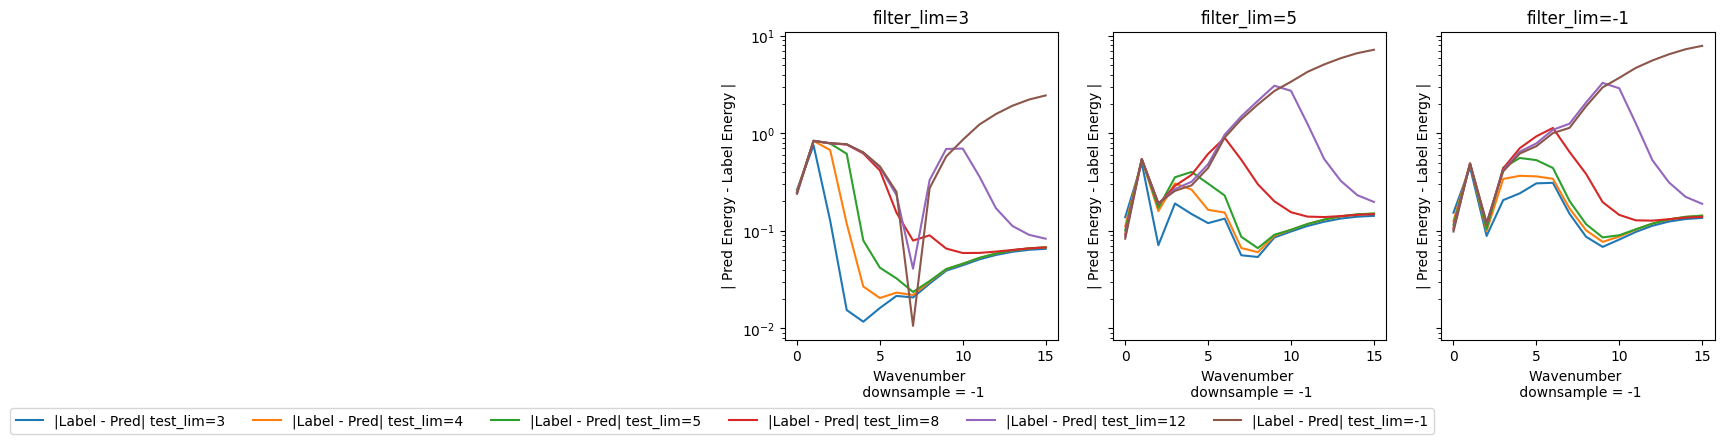

In [32]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt

fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey='row', sharex='col', figsize=(12, 4)
)
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
for y_idx, downsample_dim in enumerate([-1]):
    for x_idx, filter_lim in enumerate([3, 5, -1]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        print(f'{ckpt_name}')
        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for test_lim in [3, 4, 5, 8, 12, -1]:
            for test_down in [-1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': True,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']

                # get label + spectrum
                label_spectrum = get_energy_curve(
                    dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                # get unfiltered label specturm
                unfilter_data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': -1,
                    'img_size': 32,
                    'downsample_dim': -1,
                    'train': True,
                }

                unfilter_dataset = get_dataset(**unfilter_data_kwargs)
                unfilter_label_spectrum = get_energy_curve(
                    unfilter_dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                # get model pred + spectrum
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()
                pred_spectrum = get_energy_curve(
                    model_preds_test[:samples].reshape(samples * 1, s, s)
                )
                axes[x_idx].set_yscale('log')
                axes[x_idx].plot(
                    abs(pred_spectrum - label_spectrum) / unfilter_label_spectrum,
                    #pred_spectrum,
                    label=f'|Label - Pred| {test_lim=}',
                    #color=colors[color_idx],
                )

                #axes[x_idx].plot(
                #    label_spectrum,
                #    label=f'label {test_lim=}',
                #    linestyle=":",
                #    color=colors[color_idx],
                #)

                # sns.lineplot(df, x="epoch", y=ylabel, label=ylabel, ax=axes)
                axes[x_idx].set_xlabel(
                    f'Wavenumber \n downsample = {downsample_dim}'
                )
                # axes.get_legend().remove()
                axes[x_idx].set_ylabel('| Pred Energy - Label Energy |')
                axes[x_idx].set_title(f'{filter_lim=}')

plt.legend(bbox_to_anchor=(-0, -.2), ncols=6)
plt.tight_layout()
plt.show()

/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1_5//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/-1

/tmp/ipykernel_666841/3734137427.py:99: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


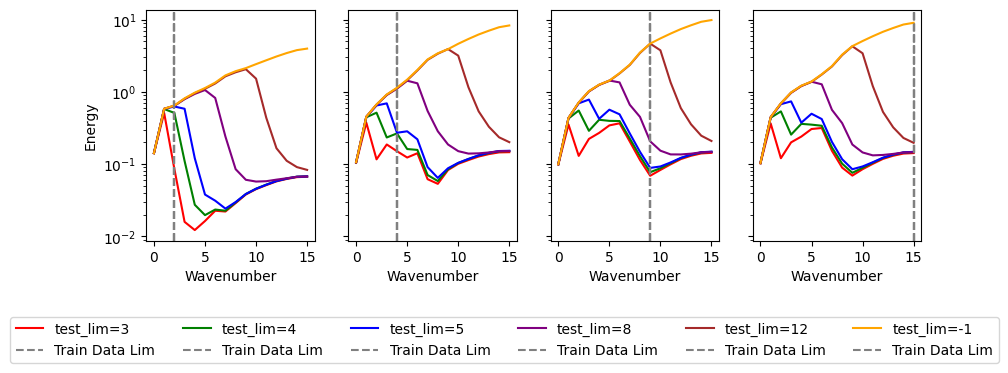

In [38]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt
import matplotlib 

fig, axes = plt.subplots(
    nrows=1, ncols=4, sharey='row', sharex='col', figsize=(10, 3)
)
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
for y_idx, downsample_dim in enumerate([-1]):
    for x_idx, filter_lim in enumerate([3, 5, 10, -1]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        print(f'{ckpt_name}')
        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for color_idx, test_lim in enumerate([3, 4, 5, 8, 12, -1]):
            for test_down in [-1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': False,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']

                # get model pred
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()

                # compute residuals
                residuals = []
                for i in range(model_preds_test.shape[0]):
                    residual = model_preds_test[i].to('cpu') - dataset[:samples]['y'].squeeze()[i]
                    residuals.append(residual)
                
                residuals = torch.stack(residuals)

                # spectrum of residuals
                residual_spectrum = get_energy_curve(
                    residuals #.reshape(samples * 1, s, s)
                )

                # get unfiltered label specturm
                unfilter_data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': -1,
                    'img_size': 32,
                    'downsample_dim': -1,
                    'train': False,
                }

                unfilter_dataset = get_dataset(**unfilter_data_kwargs)
                unfilter_label_spectrum = get_energy_curve(
                    unfilter_dataset[:samples]['y'].reshape(samples * 1, s, s)
                )

                axes[x_idx].set_yscale('log')
                axes[x_idx].plot(
                    residual_spectrum / unfilter_label_spectrum,
                    label=f'{test_lim=}',
                    color=colors[color_idx],
                )

                axes[x_idx].set_xlabel(
                    f'Wavenumber'
                )
                if filter_lim == -1:
                    filter_lim = s // 2  
                axes[x_idx].axvline(x = filter_lim - 1, color = 'grey', linestyle="--", label = 'Train Data Lim')
                if x_idx == 0:
                    axes[x_idx].set_ylabel('Energy')
                #axes[x_idx].set_title(f'{filter_lim=}')
                # TODO (MS): figure out how to adjust xtick to start at 1

plt.legend(bbox_to_anchor=(1.5, -.3), ncols=6)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/varried_filters.pdf',
    bbox_inches='tight',
)

/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/6_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/6_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/8_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/8_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/12_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/12_3/45_c

/tmp/ipykernel_666841/999069561.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


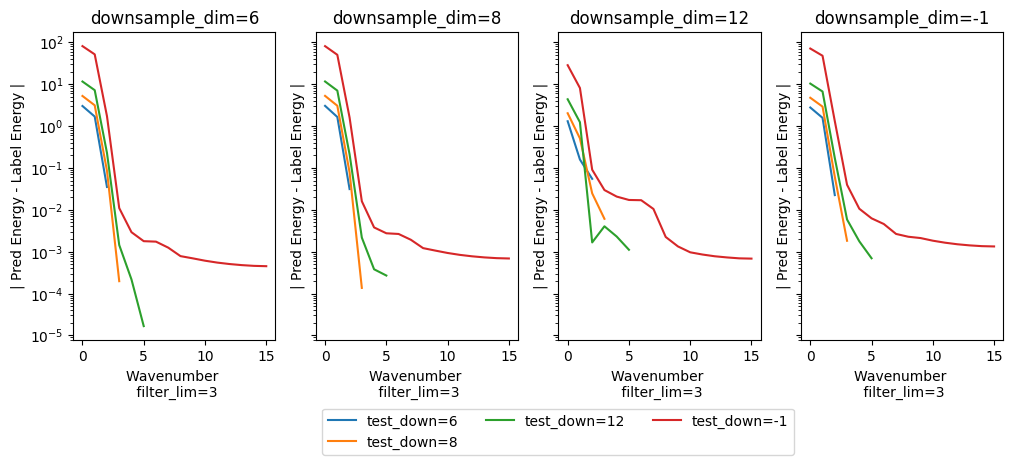

In [39]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt

fig, axes = plt.subplots(
    nrows=1, ncols=4, sharey='row', sharex='col', figsize=(12, 4)
)
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
for x_idx, downsample_dim in enumerate([6, 8, 12, -1]):
    for y_idx, filter_lim in enumerate([3]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        print(f'{ckpt_name}')
        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for test_lim in [3]:
            for test_down in [6, 8, 12, -1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': False,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']
                if data_kwargs['downsample_dim'] != -1:
                    s = data_kwargs['downsample_dim']

                # get label + spectrum
                inputs = [dataset[i]['x'] for i in range(samples)]
                labels = [dataset[i]['y'] for i in range(samples)]
                dataset_samples = {
                    'x': torch.cat(inputs),
                    'y': torch.cat(labels),
                }
                label_spectrum = get_energy_curve(
                    dataset_samples['y'].reshape(samples * 1, s, s)
                )

                # get model pred + spectrum
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()
                pred_spectrum = get_energy_curve(
                    model_preds_test[:samples].reshape(samples * 1, s, s)
                )
                axes[x_idx].set_yscale('log')
                axes[x_idx].plot(
                    abs(pred_spectrum - label_spectrum),
                    label=f'{test_down=}',
                )

                axes[x_idx].set_xlabel(f'Wavenumber \n {filter_lim=}')
                # axes.get_legend().remove()
                axes[x_idx].set_ylabel('| Pred Energy - Label Energy |')
                axes[x_idx].set_title(f'{downsample_dim=}')

plt.legend(bbox_to_anchor=(-0, -0.2), ncols=3)
plt.tight_layout()
plt.show()

/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/6_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/6_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/8_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/8_3/5_ckpt.pth
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
Loading test db for resolution 32 with 32 samples 
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/12_3//train_stats.csv
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts/12_3/45_c

/tmp/ipykernel_666841/4052377625.py:94: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


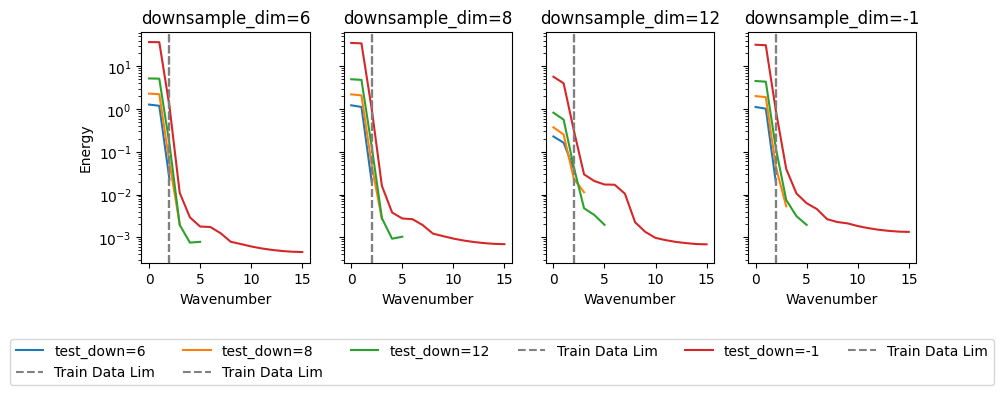

In [40]:
# Loss curves
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt

fig, axes = plt.subplots(
    nrows=1, ncols=4, sharey='row', sharex='col', figsize=(10, 3)
)
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/old_ckpts'
for x_idx, downsample_dim in enumerate([6, 8, 12, -1]):
    for y_idx, filter_lim in enumerate([3]):
        if filter_lim == -1 and downsample_dim != -1:
            continue
        ckpt_dir = f'{downsample_dim}_{filter_lim}'
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
        df = pd.read_csv(ckpt_name)

        print(f'{ckpt_name}')
        # load model
        model = get_model(
            model_name='FNO2D',
            out_channels=1,
            in_channels=1,
            hidden_channels=32,
            max_modes=16,
        ).to(device)
        ckpt_dict = load_latest_ckpt(ckpt_pth)
        model.load_state_dict(ckpt_dict['model_state_dict'])

        for test_lim in [3]:
            for test_down in [6, 8, 12, -1]:
                ylabel = f'test_lim={test_lim}_downsample={test_down}'
                # get data
                data_kwargs = {
                    'dataset_name': 'darcy',
                    'filter_lim': test_lim,
                    'img_size': 32,
                    'downsample_dim': test_down,
                    'train': False,
                }

                dataset = get_dataset(**data_kwargs)
                samples = len(dataset)
                s = data_kwargs['img_size']
                if data_kwargs['downsample_dim'] != -1:
                    s = data_kwargs['downsample_dim']
                inputs = [dataset[i]['x'] for i in range(samples)]
                labels = [dataset[i]['y'] for i in range(samples)]
                dataset_samples = {
                    'x': torch.cat(inputs),
                    'y': torch.cat(labels),
                }

                # get model pred
                dataloader = DataLoader(dataset, batch_size=32)
                model_preds_test = get_model_preds(
                    dataloader, model, device
                ).squeeze()

                # compute residuals
                residuals = []
                for i in range(model_preds_test.shape[0]):
                    residual = model_preds_test[i].to('cpu') - dataset_samples['y'].squeeze()[i]
                    residuals.append(residual)
                
                residuals = torch.stack(residuals)

                # spectrum of residuals
                residual_spectrum = get_energy_curve(
                    residuals #.reshape(samples * 1, s, s)
                )
                axes[x_idx].set_yscale('log')
                axes[x_idx].plot(
                    residual_spectrum,
                    label=f'{test_down=}',
                    #color=colors[color_idx],
                )

                axes[x_idx].set_xlabel(
                    f'Wavenumber'
                )
                if filter_lim == -1:
                    filter_lim = s // 2  
                if filter_lim == -1:
                    filter_lim = s // 2  
                axes[x_idx].axvline(x = filter_lim - 1, color = 'grey', linestyle="--", label = 'Train Data Lim')
                if x_idx == 0:
                    axes[x_idx].set_ylabel('Energy')
                axes[x_idx].set_title(f'{downsample_dim=}')
                #axes[x_idx].set_title(f'{filter_lim=}')
                # TODO (MS): figure out how to adjust xtick to start at 1

plt.legend(bbox_to_anchor=(1.5, -.3), ncols=6)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/varried_downsample.pdf',
    bbox_inches='tight',
)

# Basic Filter to NeuralOp Data

In [ ]:
# first download data
data = DarcyDataset(
    root_dir=root_dir,
    n_train=100,
    n_tests=[32, 32, 32, 32],
    batch_size=16,
    test_batch_sizes=[16, 16, 16, 16],
    train_resolution=128,  # change resolution to download different data
    test_resolutions=[16, 32, 64, 128],
)

# load darcy flow dataset


def load_darcy_flow_small(
    n_train,
    n_tests,
    data_root=root_dir,
    test_resolutions=(16, 32),
    train_resolution=16,
):
    """Docstring."""
    batch_size = 16
    test_batch_sizes = [batch_size] * len(test_resolutions)

    dataset = DarcyDataset(
        root_dir=data_root,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=False,
        encode_output=True,
        channel_dim=1,
        encoding='channel-wise',
        download=True,
    )

    # return dataloaders for backwards compat
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        persistent_workers=False,
    )

    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=1,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor


train_resolution = 16
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000,
    # batch_size=16,
    train_resolution=train_resolution,
    test_resolutions=[16, 32, 64, 128],
    n_tests=[100, 100, 100, 100],
    # test_batch_sizes=[32, 32, 32, 32],
)

In [ ]:
data.train_db[0]

In [ ]:
for _idx, batch in enumerate(train_loader):
    print(batch)
    sample = batch
    break

In [ ]:
class lowpass_filter_2d:
    """Lowpass filter the image.

    Args:
        filter_limit: frequencies > filter_lim excluded
    """

    def __init__(self, filter_limit: int, img_size: int) -> None:
        assert isinstance(filter_limit, int)
        assert isinstance(img_size, int)
        self.filter_limit = filter_limit
        self.img_size = img_size

        # assert that filter limit is less than half img_size
        assert self.filter_limit <= self.img_size // 2

        # get filter
        self.filter = get_2d_low_pass_filter(self.filter_limit, self.img_size)

    def __call__(self, sample):
        model_input, label = sample['x'], sample['y']

        # apply no filter
        if self.filter_limit == -1:
            return {'x': model_input, 'y': label}

        filter_input = filter_batch(self.filter, model_input)
        filter_label = filter_batch(self.filter, label)

        return {'x': filter_input, 'y': filter_label}


class downsample:
    """Downsize image.

    Args:
        out_size: x/y dim of downsampled obj
    """

    def __init__(self, out_size: int) -> None:
        assert isinstance(out_size, int)
        self.out_size = out_size

    def __call__(self, sample):
        model_input, label = sample['x'], sample['y']

        # apply no downsample
        if self.out_size == -1:
            return {'x': model_input, 'y': label}

        downsample_input = f.interpolate(
            model_input,
            size=(self.out_size, self.out_size),
            mode='bicubic',
            antialias=True,
        )

        downsample_label = f.interpolate(
            model_input,
            size=(self.out_size, self.out_size),
            mode='bicubic',
            antialias=True,
        )

        return {'x': downsample_input, 'y': downsample_label}

In [ ]:
filter_lim = 2
img_size = 16
lowpass_transform = lowpass_filter_2d(filter_lim, img_size)
downsample_transform = downsample(filter_lim * 2 + 1)
lowpass_transform(sample)['x']
downsample_transform(sample)['x'].shape

In [ ]:
filtered_batch = lowpass_transform(sample)['y']

samples = 16
s = 16
filtered_sp = get_energy_curve(
    filtered_batch[:samples].reshape(samples * 1, s, s)
)

unfiltered_sp = get_energy_curve(
    sample['y'][:samples].reshape(samples * 1, s, s)
)

plt.plot(filtered_sp, color='blue', label='filtered')
plt.plot(unfiltered_sp, color='red', label='unfiltered')
plt.ylabel('Energy')
plt.xlabel('Wavenumber')
plt.legend()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample['y'][0, 0, :, :])
axes[0].set_title('Unfiltered')
axes[1].imshow(filtered_batch[0, 0, :, :])
axes[1].set_title(f'Filtered {filter_lim=}')

In [ ]:
lowpass = lowpass_transform(sample)
downsampled_batch = downsample_transform(lowpass)['y']
# filtered_batch = lowpass_transform(sample)['x']

samples = 16
s = 16
filtered_sp = get_energy_curve(
    downsampled_batch[:samples].reshape(
        samples * 1, filter_lim * 2 + 1, filter_lim * 2 + 1
    )
)

unfiltered_sp = get_energy_curve(
    sample['y'][:samples].reshape(samples * 1, s, s)
)

plt.plot(filtered_sp, color='blue', label='filtered_downsample')
plt.plot(unfiltered_sp, color='red', label='unfiltered')
plt.ylabel('Energy')
plt.xlabel('Wavenumber')
plt.legend()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample['y'][0, 0, :, :])
axes[0].set_title('Unfiltered')
axes[1].imshow(downsampled_batch[0, 0, :, :])
axes[1].set_title(f'{filter_lim=}, downsample to {filter_lim * 2 + 1}')

# PDE BENCH

In [2]:
# https://github.com/pdebench/PDEBench/blob/main/pdebench/models/fno/utils.py
from __future__ import annotations

import math as mt
from pathlib import Path

import h5py
import torch
from torch.utils.data import Dataset


class FNODatasetSingle(Dataset):
    def __init__(
        self,
        filename,
        initial_step=10,
        saved_folder='../data/',
        reduced_resolution=1,
        reduced_resolution_t=1,
        reduced_batch=1,
        if_test=False,
        test_ratio=0.1,
        num_samples_max=-1,
    ):
        """:param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """
        # Define path to files
        root_path = Path(Path(saved_folder).resolve()) / filename
        if filename[-2:] != 'h5':
            # print(".HDF5 file extension is assumed hereafter")

            with h5py.File(root_path, 'r') as f:
                keys = list(f.keys())
                keys.sort()
                if 'tensor' not in keys:
                    _data = np.array(
                        f['density'], dtype=np.float32
                    )  # batch, time, x,...
                    idx_cfd = _data.shape
                    if len(idx_cfd) == 3:  # 1D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                3,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f['pressure'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f['Vx'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch

                        self.grid = np.array(
                            f['x-coordinate'], dtype=np.float32
                        )
                        self.grid = torch.tensor(
                            self.grid[::reduced_resolution], dtype=torch.float
                        ).unsqueeze(-1)
                        # print(self.data.shape)
                    if len(idx_cfd) == 4:  # 2D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                idx_cfd[3] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                4,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f['pressure'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f['Vx'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch
                        # Vy
                        _data = np.array(
                            f['Vy'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 1))
                        self.data[..., 3] = _data  # batch, x, t, ch

                        x = np.array(f['x-coordinate'], dtype=np.float32)
                        y = np.array(f['y-coordinate'], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing='ij')
                        self.grid = torch.stack((X, Y), axis=-1)[
                            ::reduced_resolution, ::reduced_resolution
                        ]

                    if len(idx_cfd) == 5:  # 3D
                        self.data = np.zeros(
                            [
                                idx_cfd[0] // reduced_batch,
                                idx_cfd[2] // reduced_resolution,
                                idx_cfd[3] // reduced_resolution,
                                idx_cfd[4] // reduced_resolution,
                                mt.ceil(idx_cfd[1] / reduced_resolution_t),
                                5,
                            ],
                            dtype=np.float32,
                        )
                        # density
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 0] = _data  # batch, x, t, ch
                        # pressure
                        _data = np.array(
                            f['pressure'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 1] = _data  # batch, x, t, ch
                        # Vx
                        _data = np.array(
                            f['Vx'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 2] = _data  # batch, x, t, ch
                        # Vy
                        _data = np.array(
                            f['Vy'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 3] = _data  # batch, x, t, ch
                        # Vz
                        _data = np.array(
                            f['Vz'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data, (0, 2, 3, 4, 1))
                        self.data[..., 4] = _data  # batch, x, t, ch

                        x = np.array(f['x-coordinate'], dtype=np.float32)
                        y = np.array(f['y-coordinate'], dtype=np.float32)
                        z = np.array(f['z-coordinate'], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        z = torch.tensor(z, dtype=torch.float)
                        X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
                        self.grid = torch.stack((X, Y, Z), axis=-1)[
                            ::reduced_resolution,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]

                else:  # scalar equations
                    ## data dim = [t, x1, ..., xd, v]
                    _data = np.array(
                        f['tensor'], dtype=np.float32
                    )  # batch, time, x,...
                    if len(_data.shape) == 3:  # 1D
                        _data = _data[
                            ::reduced_batch,
                            ::reduced_resolution_t,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :], (0, 2, 1))
                        self.data = _data[:, :, :, None]  # batch, x, t, ch

                        self.grid = np.array(
                            f['x-coordinate'], dtype=np.float32
                        )
                        self.grid = torch.tensor(
                            self.grid[::reduced_resolution], dtype=torch.float
                        ).unsqueeze(-1)
                    if len(_data.shape) == 4:  # 2D Darcy flow
                        # u: label
                        _data = _data[
                            ::reduced_batch,
                            :,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        # if _data.shape[-1]==1:  # if nt==1
                        #    _data = np.tile(_data, (1, 1, 1, 2))
                        self.data = _data
                        # nu: input
                        _data = np.array(
                            f['nu'], dtype=np.float32
                        )  # batch, time, x,...
                        _data = _data[
                            ::reduced_batch,
                            None,
                            ::reduced_resolution,
                            ::reduced_resolution,
                        ]
                        ## convert to [x1, ..., xd, t, v]
                        _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                        self.data = np.concatenate([_data, self.data], axis=-1)
                        self.data = self.data[
                            :, :, :, :, None
                        ]  # batch, x, y, t, ch

                        x = np.array(f['x-coordinate'], dtype=np.float32)
                        y = np.array(f['y-coordinate'], dtype=np.float32)
                        x = torch.tensor(x, dtype=torch.float)
                        y = torch.tensor(y, dtype=torch.float)
                        X, Y = torch.meshgrid(x, y, indexing='ij')
                        self.grid = torch.stack((X, Y), axis=-1)[
                            ::reduced_resolution, ::reduced_resolution
                        ]

        elif filename[-2:] == 'h5':  # SWE-2D (RDB)
            # print(".H5 file extension is assumed hereafter")

            with h5py.File(root_path, 'r') as f:
                keys = list(f.keys())
                keys.sort()

                data_arrays = [
                    np.array(f[key]['data'], dtype=np.float32) for key in keys
                ]
                _data = torch.from_numpy(
                    np.stack(data_arrays, axis=0)
                )  # [batch, nt, nx, ny, nc]
                _data = _data[
                    ::reduced_batch,
                    ::reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                    ...,
                ]
                _data = torch.permute(
                    _data, (0, 2, 3, 1, 4)
                )  # [batch, nx, ny, nt, nc]
                gridx, gridy = (
                    np.array(f['0023']['grid']['x'], dtype=np.float32),
                    np.array(f['0023']['grid']['y'], dtype=np.float32),
                )
                mgridX, mgridY = np.meshgrid(gridx, gridy, indexing='ij')
                _grid = torch.stack(
                    (torch.from_numpy(mgridX), torch.from_numpy(mgridY)),
                    axis=-1,
                )
                _grid = _grid[::reduced_resolution, ::reduced_resolution, ...]
                _tsteps_t = torch.from_numpy(
                    np.array(f['0023']['grid']['t'], dtype=np.float32)
                )

                tsteps_t = _tsteps_t[::reduced_resolution_t]
                self.data = _data
                self.grid = _grid
                self.tsteps_t = tsteps_t

        if num_samples_max > 0:
            num_samples_max = min(num_samples_max, self.data.shape[0])
        else:
            num_samples_max = self.data.shape[0]

        test_idx = int(num_samples_max * test_ratio)
        if if_test:
            self.data = self.data[:test_idx]
        else:
            self.data = self.data[test_idx:num_samples_max]

        # Time steps used as initial conditions
        self.initial_step = initial_step

        self.data = (
            self.data
            if torch.is_tensor(self.data)
            else torch.tensor(self.data)
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx, ..., : self.initial_step, :],
            self.data[idx],
            self.grid,
        )


class FNODatasetMult(Dataset):
    def __init__(
        self,
        filename,
        initial_step=10,
        saved_folder='../data/',
        if_test=False,
        test_ratio=0.1,
    ):
        """:param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """
        # Define path to files
        self.file_path = Path(saved_folder + filename + '.h5').resolve()

        # Extract list of seeds
        with h5py.File(self.file_path, 'r') as h5_file:
            data_list = sorted(h5_file.keys())

        test_idx = int(len(data_list) * (1 - test_ratio))
        if if_test:
            self.data_list = np.array(data_list[test_idx:])
        else:
            self.data_list = np.array(data_list[:test_idx])

        # Time steps used as initial conditions
        self.initial_step = initial_step

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Open file and read data
        with h5py.File(self.file_path, 'r') as h5_file:
            seed_group = h5_file[self.data_list[idx]]

            # data dim = [t, x1, ..., xd, v]
            data = np.array(seed_group['data'], dtype='f')
            data = torch.tensor(data, dtype=torch.float)

            # convert to [x1, ..., xd, t, v]
            permute_idx = list(range(1, len(data.shape) - 1))
            permute_idx.extend([0, -1])
            data = data.permute(permute_idx)

            # Extract spatial dimension of data
            dim = len(data.shape) - 2

            # x, y and z are 1-D arrays
            # Convert the spatial coordinates to meshgrid
            if dim == 1:
                grid = np.array(seed_group['grid']['x'], dtype='f')
                grid = torch.tensor(grid, dtype=torch.float).unsqueeze(-1)
            elif dim == 2:
                x = np.array(seed_group['grid']['x'], dtype='f')
                y = np.array(seed_group['grid']['y'], dtype='f')
                x = torch.tensor(x, dtype=torch.float)
                y = torch.tensor(y, dtype=torch.float)
                X, Y = torch.meshgrid(x, y, indexing='ij')
                grid = torch.stack((X, Y), axis=-1)
            elif dim == 3:
                x = np.array(seed_group['grid']['x'], dtype='f')
                y = np.array(seed_group['grid']['y'], dtype='f')
                z = np.array(seed_group['grid']['z'], dtype='f')
                x = torch.tensor(x, dtype=torch.float)
                y = torch.tensor(y, dtype=torch.float)
                z = torch.tensor(z, dtype=torch.float)
                X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
                grid = torch.stack((X, Y, Z), axis=-1)

        return data[..., : self.initial_step, :], data, grid

In [99]:
# https://github.com/pdebench/PDEBench/blob/main/pdebench/models/fno/utils.py
from __future__ import annotations

import math as mt
from pathlib import Path

import h5py
import torch
from torch.utils.data import Dataset


class FNODatasetSingle(Dataset):
    def __init__(
        self,
        filename,
        initial_step=10,
        saved_folder='../data/',
        reduced_resolution=1,
        reduced_resolution_t=1,
        reduced_batch=1,
        if_test=False,
        test_ratio=0.1,
        num_samples_max=-1,
        transform: Compose = None,
    ):
        """:param filename: filename that contains the dataset
        :type filename: STR
        :param filenum: array containing indices of filename included in the dataset
        :type filenum: ARRAY
        :param initial_step: time steps taken as initial condition, defaults to 10
        :type initial_step: INT, optional

        """
        self.transform = transform
        
        # Define path to files
        root_path = Path(Path(saved_folder).resolve()) / filename
        if filename[-2:] != 'h5':
            # print(".HDF5 file extension is assumed hereafter")

            with h5py.File(root_path, 'r') as f:
                keys = list(f.keys())
                keys.sort()

                ## data dim = [t, x1, ..., xd, v]
                _data = np.array(
                    f['tensor'], dtype=np.float32
                )  # batch, time, x,...
                if len(_data.shape) == 3:  # 1D
                    _data = _data[
                        ::reduced_batch,
                        ::reduced_resolution_t,
                        ::reduced_resolution,
                    ]
                    ## convert to [x1, ..., xd, t, v]
                    _data = np.transpose(_data[:, :, :], (0, 2, 1))
                    self.data = _data[:, :, :, None]  # batch, x, t, ch

                    self.grid = np.array(
                        f['x-coordinate'], dtype=np.float32
                    )
                    self.grid = torch.tensor(
                        self.grid[::reduced_resolution], dtype=torch.float
                    ).unsqueeze(-1)
                if len(_data.shape) == 4:  # 2D Darcy flow
                    # u: label
                    _data = _data[
                        ::reduced_batch,
                        :,
                        ::reduced_resolution,
                        ::reduced_resolution,
                    ]
                    ## convert to [x1, ..., xd, t, v]
                    _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                    # if _data.shape[-1]==1:  # if nt==1
                    #    _data = np.tile(_data, (1, 1, 1, 2))
                    self.data = _data
                    # nu: input
                    _data = np.array(
                        f['nu'], dtype=np.float32
                    )  # batch, time, x,...
                    _data = _data[
                        ::reduced_batch,
                        None,
                        ::reduced_resolution,
                        ::reduced_resolution,
                    ]
                    ## convert to [x1, ..., xd, t, v]
                    _data = np.transpose(_data[:, :, :, :], (0, 2, 3, 1))
                    self.data = np.concatenate([_data, self.data], axis=-1)
                    self.data = self.data[
                        :, :, :, :,  #None
                    ]  # batch, x, y, t, ch

                    x = np.array(f['x-coordinate'], dtype=np.float32)
                    y = np.array(f['y-coordinate'], dtype=np.float32)
                    x = torch.tensor(x, dtype=torch.float)
                    y = torch.tensor(y, dtype=torch.float)
                    X, Y = torch.meshgrid(x, y, indexing='ij')
                    self.grid = torch.stack((X, Y), axis=-1)[
                        ::reduced_resolution, ::reduced_resolution
                    ]


        if num_samples_max > 0:
            num_samples_max = min(num_samples_max, self.data.shape[0])
        else:
            num_samples_max = self.data.shape[0]

        test_idx = int(num_samples_max * test_ratio)
        if if_test:
            self.data = self.data[:test_idx]
        else:
            self.data = self.data[test_idx:num_samples_max]

        # Time steps used as initial conditions
        self.initial_step = initial_step

        self.data = (
            self.data
            if torch.is_tensor(self.data)
            else torch.tensor(self.data)
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        unsqueeze_dim = 0
        if type(idx) != int:
            unsqueeze_dim = 1
        sample = {
            "x": self.data[idx, :, :, 0].unsqueeze(unsqueeze_dim),
            "y": self.data[idx, ..., 1].unsqueeze(unsqueeze_dim),
            #self.grid,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [100]:
data = FNODatasetSingle(
    filename='2D_DarcyFlow_beta0.01_Train.hdf5',
    initial_step=1,
    saved_folder='/pscratch/sd/m/mansisak/PDEBench/pdebench_data/2D/DarcyFlow/',
    reduced_resolution=1,
    reduced_resolution_t=1,
    reduced_batch=1,
    if_test=False,
    test_ratio=0.1,
    num_samples_max=-1,
)

print(data[0]['x'].shape)

self.data.shape=torch.Size([9000, 128, 128, 2])
torch.Size([1, 128, 128])


In [98]:
data[0:10]['x'].shape

slice(0, 10, None)


torch.Size([10, 1, 128, 128])

In [60]:
torch.equal(initial, label)

False

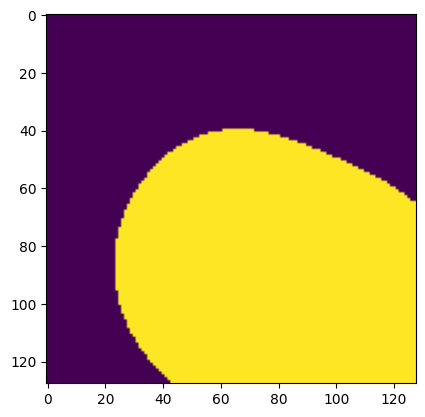

In [74]:
plt.imshow(initial[:, :])

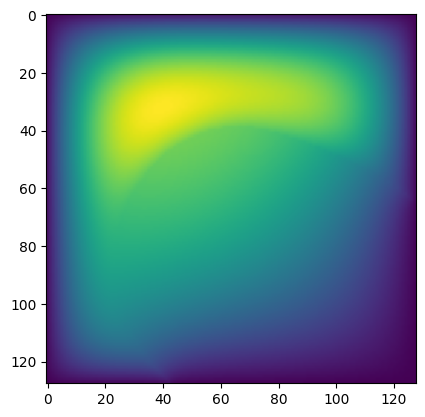

In [75]:
plt.imshow(label[:, :])

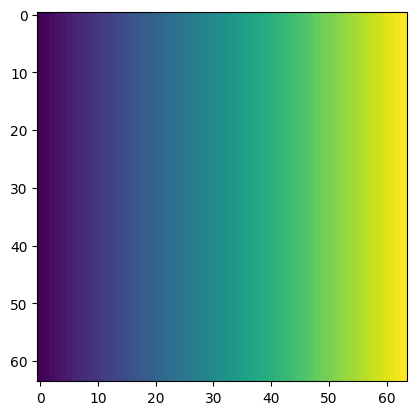

In [7]:
plt.imshow(grid[:, :, 1])

# TODO: produce data loader which can apply a specific filter and use it to train the model!!